# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [204]:
import pyaudio
from bs4 import BeautifulSoup
import requests
import io
import os
import numpy as np
def transcribe_file(speech_file):
    """Transcribe the given audio file."""
    from google.cloud import speech
    from google.cloud.speech import enums
    from google.cloud.speech import types
    client = speech.SpeechClient()

    # [START migration_sync_request]
    # [START migration_audio_config_file]
    with io.open(speech_file, 'rb') as audio_file:
        content = audio_file.read()

    audio = types.RecognitionAudio(content=content)
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code='en-US')
    # [END migration_audio_config_file]

    # [START migration_sync_response]
    response = client.recognize(config, audio)
    # [END migration_sync_request]
    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        print('Transcript: {}'.format(result.alternatives[0].transcript))
    return result.alternatives[0].transcript
    # [END migration_sync_response]
# [END def_transcribe_file]



In [ ]:
#record a file and save it

chunk = 1024
FORMAT = pyaudio.paInt32
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "new2.wav"
p = pyaudio.PyAudio()
print('created object')
stream = p.open(format = FORMAT,
    channels = CHANNELS,
    rate = RATE,
    input = True,
    frames_per_buffer = chunk,
               input_device_index = 1)
print('created stream')
all = []
for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
    print('hello')
    data = stream.read(chunk)
    print('hey')
    all.append(data)
print("* done recording")
stream.close()
p.terminate()
import wave
data = b"".join(all)
wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(data)
wf.close()

created object
created stream
hello


In [14]:
#!export GOOGLE_APPLICATION_CREDENTIALS="/home/hayley/Downloads/My First Project-8492b98d533d.json"
#get the transcription of the file
transcript = transcribe_file('/home/hayley/python-docs-samples/speech/cloud-client/resources/audio.raw')

Transcript: how old is the Brooklyn Bridge


In [23]:
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.mime.text import MIMEText
from email import encoders as Encoders
from email.utils import COMMASPACE, formatdate

def mail(sender, pwd, to, subject, text, files=[]):
    msg = MIMEMultipart()
    msg["From"] = sender
    msg["To"] = COMMASPACE.join(to)
    msg["Date"] = formatdate(localtime=True)
    msg["Subject"] = subject
    msg.attach(MIMEText(text))
    for file in files:
        part = MIMEBase("application", "octet-stream")
        part.set_payload( open(file,"rb").read() )
        Encoders.encode_base64(part)
        part.add_header("Content-Disposition", "attachment; filename='%s'"
                       % os.path.basename(file))
        msg.attach(part)
    # Note that we need to designate the remote SMTP server we want to use.
    mailServer = smtplib.SMTP("smtp.gmail.com", 587)
    mailServer.starttls()
    mailServer.login(sender, pwd)
    mailServer.sendmail(sender, to, msg.as_string())
    mailServer.close()


In [37]:
def send_mail(transcript):
    t = transcript.split()
    try:
        subjind = t.index('subject')
    except: 
        try:
            subjind = t.index('Subject')
        except:
            print('no subject found!')
            return
    try:
        bodyind = t.index('body')
    except: 
        try:
            bodyind = t.index('Body')
        except:
            print('no body found!')
            return    
        
    if subjind < bodyind:
        subject_text = [s for i, s in enumerate(t) if i > subjind and i < bodyind]
        body_text = [s for i, s in enumerate(t) if i > bodyind]
    else:
        subject_text = [s for i, s in enumerate(t) if i > subjind]
        body_text = [s for i, s in enumerate(t) if i > bodyind and i < subjind]
    subject_text = ' '.join(subject_text)
    body_text = ' '.join(body_text)
        
    mail('hbfake6','hawkfrost','hayleybounds@gmail.com', subject_text, body_text)

In [318]:
def tell_joke():
    jokes_req = requests.get(
        "http://www.quickfunnyjokes.com/funnythoughts.html")
    soup = BeautifulSoup(jokes_req.text,"html.parser")
    #all but the last item surrounded by span are joke sections, but the first and last two are weirdly formatted, so skip them
    joke_secs = soup.findAll('span')[1:len(soup.findAll('span'))-4]
    #convert this to list of lists of jokes, and convert from beautifulsoup navigable string type to a normal string
    jokes_as_strings = [[str(s) for s in sec.contents] for sec in joke_secs]
    #then randomly select one of the 7 joke sections
    selection = np.random.randint(0,4)
    joke_array = np.asarray(jokes_as_strings[selection])[0:len(jokes_as_strings[1])-1:4]
    #get rid of some weird leftover formatting
    joke_array = [s.replace('\n','') for s in joke_array]
    joke_array = [s.replace('â',"'") for s in joke_array]
    #and then select a random joke from that subset of jokes
    print(joke_array[np.random.randint(0, len(joke_array))])


In [ ]:
def do_math(transcript):
    pass

In [18]:
# decide what action to take based on the text in transcript
if 'email' in transcript | 'mail' in transcript:
    send_mail(transcript)
elif 'joke' in transcript:
    tell_joke()
else:
    do_math(transcript)
    

Bridge


Text(0.5,1,'Audio Analysis')

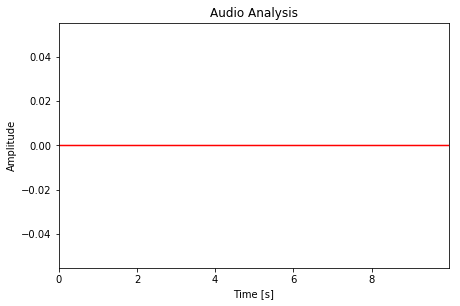

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

integer_data = fromstring(data, dtype=np.int32)
time = arange(size(integer_data)) / float(RATE)
plot_title = ("Audio Analysis")

fig = plt.figure(figsize=(7, 4.5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(time, integer_data, color="red", linestyle="-")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
ax1.set_xlim(min(time), max(time))
ax1.set_title(plot_title)

# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.